## Haberman Breast Cancer Classification

In this project, i will use a small breast cancer survival dataset, referred to generally as the
Haberman Dataset. The dataset describes breast cancer patient data and the outcome is patient
survival. Specifically whether the patient survived for five years or longer, or whether the
patient did not survive. This is a standard dataset used in the study of imbalanced classification.
According to the dataset description, the breast cancer surgery operations were conducted
between 1958 and 1970 at the University of Chicago’s Billings Hospital. There are 306 examples
in the dataset, and there are 3 input variables; they are:
- The age of the patient at the time of the operation.
- The two-digit year of the operation.
- The number of positive axillary nodes detected, a measure of a cancer has spread.
As such, i have no control over the selection of cases that make up the dataset or features
to use in those cases, other than what is available in the dataset. Although the dataset describes
breast cancer patient survival, given the small dataset size and the fact the data is based on
breast cancer diagnosis and operations many decades ago, any models built on this dataset are
not expected to generalize.
To be crystal clear, I am  not solving breast cancer. I am exploring a standard imbalanced
classification dataset. i choose to frame this dataset as the prediction of a probability of
patient survival. That is: Given patient breast cancer surgery details, what is the probability of
survival of the patient to five years or more?
This will provide the basis for exploring probabilistic algorithms that can predict a probability
instead of a class label and metrics for evaluating models that predict probabilities instead of
class labels. Next, let’s take a closer look at the data.


In [1]:
# compare probabilistic model on the haberman dataset

import pandas as pd 
import numpy as np 
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier

In [16]:
# loading the dataset
filepath = "E:\IMBALANCE ANALYSIS\haberman.csv"
columns = ['age', 'year', 'nodes', 'class'] # Given the columns name
data = pd.read_csv(filepath, header=None, names=columns)
data.head(10)

,age,year,nodes,class
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
5,33,58,10,1
6,33,60,0,1
7,34,59,0,2
8,34,66,9,2
9,34,58,30,1


calling the describe() function to create a summary of each column and print
the contents of the report. A summary for a column includes useful details like the min and
max values, the mean and standard deviation of which are useful if the variable has a Gaussian
distribution, and the 25th, 50th, and 75th quartiles, which are useful if the variable does not
have a Gaussian distribution.


In [21]:
# summarize each column

reports = data.describe()
print(reports.T)

       count       mean        std   min   25%   50%    75%   max
age    306.0  52.457516  10.803452  30.0  44.0  52.0  60.75  83.0
year   306.0  62.852941   3.249405  58.0  60.0  63.0  65.75  69.0
nodes  306.0   4.026144   7.189654   0.0   0.0   1.0   4.00  52.0
class  306.0   1.264706   0.441899   1.0   1.0   1.0   2.00   2.0


Looking at the age, I can see that the youngest patient was
30 and the oldest was 83; that is quite a range. The mean patient age was about 52 years. If the
occurrence of cancer is somewhat random, we might expect the age distribution to be Gaussian.
I can see that all operations were performed between 1958 and 1969. If the number of
breast cancer patients is somewhat fixed over time, we might expect this variable to have a
uniform distribution. We can see nodes have values between 0 and 52. This might be a cancer
diagnostic related to lymphatic nodes.

All variables are integers. Therefore, it might be helpful to look at each variable as a
histogram to get an idea of the variable distribution. This might be helpful in case we choose
models later that are sensitive to the data distribution or scale of the data, in which case, I
might need to transform or rescale the data. We can create a histogram of each variable in the
DataFrame by calling the hist() function

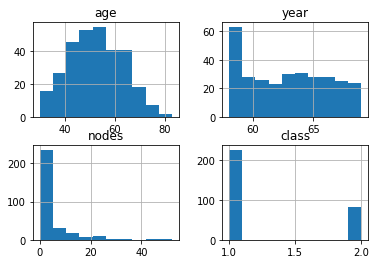

In [23]:
# creating a histogram plot of each variable
data.hist()
pyplot.show()

Running the example creates a histogram for each variable. i can see that age appears
to have a Gaussian distribution, as we might have expected.I can also see that year has
a uniform distribution, mostly, with an outlier in the first year showing nearly double the
number of operations. We can see nodes has an exponential type distribution with perhaps most
examples showing 0 nodes, with a long tail of values after that. A transform to un-bunch this
distribution might help some models later on. Finally, we can see the two-class values with an
unequal class distribution, showing perhaps 2- or 3-times more survival than non-survival cases.


In [29]:
# It may be helpful to know how imbalanced the dataset actually is. I can use the Counter
# object to count the number of examples in each class, then use those counts to summarize the distribution

# summarize the class distribution

from collections import Counter

target = data['class'].values
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=225, Percentage=73.529%
Class=2, Count=81, Percentage=26.471%


Running the example summarizes the class distribution for the dataset. I can see that
class 1 for survival has the most examples at 225, or about 74 percent of the dataset. I can
see class 2 for non-survival has fewer examples at 81, or about 26 percent of the dataset. The
class distribution is skewed, but it is not severely imbalanced

In [56]:
# baseline model and test harness for the haberman dataset
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import brier_score_loss
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

#### Model Test and Baseline Result
I will evaluate candidate models using repeated stratified k-fold cross-validation. The k-fold
cross-validation procedure provides a good general estimate of model performance that is not
too optimistically biased, at least compared to a single train-test split. We will use k = 10,
meaning each fold will contain 306
10 or about 30 examples.
Stratified means that each fold will contain the same mixture of examples by class, that is
about 74 percent to 26 percent survival and non-survival. Repeated means that the evaluation
process will be performed multiple times to help avoid fluke results and better capture the
variance of the chosen model. We will use three repeats. This means a single model will be
fit and evaluated 10 × 3 (30) times and the mean and standard deviation of these runs will be
reported. This can be achieved using the RepeatedStratifiedKFold scikit-learn class.
Given that we are interested in predicting a probability of survival, I need a performance
metric that evaluates the skill of a model based on the predicted probabilities. In this case,
I will use the Brier score that calculates the mean squared error between the predicted
probabilities and the expected probabilities. This
can be calculated using the brier score loss() scikit-learn function. This score is minimized,
with a perfect score of 0.0. We can invert the score to be maximizing by comparing a predicted
score to a reference score, showing how much better the model is compared to the reference
between 0.0 for the same, to 1.0 with perfect skill. Any models that achieve a score less than
0.0 represents less skill than the reference model. This is called the Brier Skill Score, or BSS for
short.
It is customary for an imbalanced dataset to model the minority class as a positive class. In
this dataset, the positive class represents non-survival. This means that we will be predicting
the probability of non-survival and will need to calculate the complement of the predicted
probability in order to get the probability of survival. As such, we can map the 1 class values
(survival) to the negative case with a 0 class label, and the 2 class values (non-survival) to the
positive case with a class label of 1. This can be achieved using the LabelEncoder class. For
example, the load dataset() function below will load the dataset, split the variable columns
into input and outputs, and then encode the target variable to 0 and 1 values

In [60]:
# load the dataset
def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    # retrieve numpy array
    data = data.values

    #split into input and output elements
    X, y = data[:, :-1], data[:, -1]


    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)

    return X, y

Next, i can calculate the Brier skill score for a model. First, i need a Brier score for a
reference prediction. A reference prediction for a problem in which i am  predicting probabilities
is the probability of the positive class label in the dataset. In this case, the positive class
label represents non-survival and occurs about 26% in the dataset. Therefore, predicting about
0.26471 represents the worst-case or baseline performance for a predictive model on this dataset.
Any model that has a Brier score better than this has some skill, where as any model that
as a Brier score lower than this has no skill. The Brier Skill Score captures this important
relationship. We can calculate the Brier score for this default prediction strategy automatically
for each training set in the k-fold cross-validation process, then use it as a point of comparison
for a given model.

In [39]:
# calculate reference brier score
ref_probs = [0.26471 for _ in range(len(y))]
bs_ref = brier_score_loss(y, ref_probs)


In [54]:
# calculate brier skill score (BSS)
def brier_skill_score(y_true, y_prob):

    # calculate reference brier score
    ref_probs = [0.26471 for _ in range(len(y_true))]
    bs_ref = brier_score_loss(y_true, ref_probs)

    # calculate model brier score
    bs_model = brier_score_loss(y_true, y_prob)
    
    # calculate skill score
    return 1.0 - (bs_model / bs_ref)

Next, i can make use of the brier skill score() function to evaluate a model using
repeated stratified k-fold cross-validation. To use our custom performance metric, i can
use the make scorer() scikit-learn function that takes the name of our custom function and
creates a metric that i can use to evaluate models with the scikit-learn API. i will set the
needs proba argument to True to ensure that models that are evaluated make predictions using
the predict proba() function to ensure they give probabilities instead of class labels.

In [55]:
# evaluate a model
def evaluate_model(X, y, model):

    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # define the model evaluation metric
    metric = make_scorer(brier_skill_score, needs_proba=True)
    
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores


The evaluate model() function below defines the evaluation procedure with our custom
evaluation metric, taking the entire training dataset and model as input, then returns the sample
of scores across each fold and each repeat.

In [61]:
# define the location of the dataset
full_path = "E:\IMBALANCE ANALYSIS\haberman.csv"

# load the dataset
X, y = load_dataset(full_path)

# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

# define the reference model
model = DummyClassifier(strategy='prior')

# In this case, i will be evaluate the baseline strategy of predicting the distribution of positive
# examples in the training set as the probability of each case in the test set. This can be
# implemented automatically using the DummyClassifier class and setting the strategy to
# ‘prior’ that will predict the prior probability of each class in the training dataset, which for
# the positive class we know is about 0.26471

# evaluate the model
scores = evaluate_model(X, y, model)

# summarize performance
print('Mean BSS: %.3f (%.3f)' % (mean(scores), std(scores)))



(306, 3) (306,) Counter({0: 225, 1: 81})
Mean BSS: -0.000 (0.000)


Running the example first loads the dataset and reports the number of cases correctly as
306 and the distribution of class labels for the negative and positive cases as we expect. The
DummyClassifier with  default strategy is then evaluated using repeated stratified k-fold
cross-validation and the mean and standard deviation of the Brier Skill Score is reported as 0.0.
This is as we expected, as we are using the test harness to evaluate the reference strategy.

## Evaluating Probabilistic Models
In this section of the code, i will use the test harness developed in the previous section to evaluate a suite
of algorithms and then improvements to those algorithms, such as data preparation schemes.


I will evaluate a suite of models that are known to be effective at predicting probabilities.
Specifically, these are models that are fit under a probabilistic framework and explicitly predict a
calibrated probability for each example. As such, this makes them well-suited to this dataset, even
with the class imbalance. I will evaluate the following six probabilistic models implemented
with the scikit-learn library:
- Logistic Regression (LR)
- Linear Discriminant Analysis (LDA)
- Quadratic Discriminant Analysis (QDA)
- Gaussian Naive Bayes (GNB)
- Multinomial Naive Bayes (MNB)
- Gaussian Process (GPC)


I am interested in directly comparing the results from each of these algorithms. Each algorithm will be compare based on the mean score, as well as based on their distribution of scores.

I define a function to create models that we want to evaluate, each with their default
configuration or configured as to not produce a warning.


>LR 0.060 (0.143)
>LDA 0.064 (0.154)
>QDA 0.027 (0.221)
>GNB 0.012 (0.212)
>GPC -0.142 (0.041)


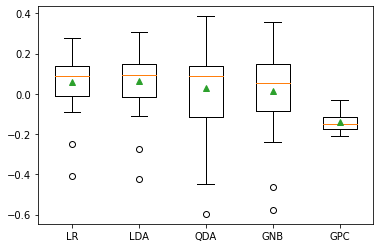

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier



# defining models to test
def get_models():
    models, names = list(), list()

    # LR
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR')

    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')

    # QDA
    models.append(QuadraticDiscriminantAnalysis())
    names.append('QDA')

    # GNB
    models.append(GaussianNB())
    names.append('GNB')

    # MNB
    #models.append(MultinomialNB())
    #names.append('MNB')

    # GPC
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    return models, names


# define models
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):

    # evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)

    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

    
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()




The results suggest that only two of the algorithms are not skillful, showing
negative scores, and that perhaps the LR and LDA algorithms are the best performing.


A box and whisker plot was created summarizing the distribution of results. Interestingly,
most if not all algorithms show a spread indicating that they may be unskillful on some of the
runs. The distribution between the two top-performing models appears roughly equivalent, so
choosing a model based on mean performance might be a good start

## Model Evaluation With Scaled Inputs
It can be a good practice to scale data for some algorithms if the variables have different units
of measure, as they do in this case. Algorithms like the LR and LDA are sensitive to the
distribution of the data and assume a Gaussian distribution for the input variables, which i
don’t have in all cases.

Nevertheless, i can test the algorithms with standardization, where each variable is shifted
to a zero mean and unit standard deviation. I will drop the MNB algorithm as it does not
support negative input values. I can achieve this by wrapping each model in a Pipeline
where the first step is a StandardScaler, which will correctly be fit on the training dataset and
applied to the test dataset within each k-fold cross-validation evaluation, preventing any data
leakage

>LR 0.062 (0.140)
>LDA 0.064 (0.154)
>QDA 0.027 (0.221)
>GNB 0.012 (0.212)
>GPC 0.097 (0.133)


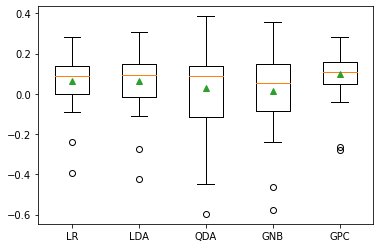

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# define models
models, names = get_models()
results = list()

# evaluate each model
for i in range(len(models)):

    # create a pipeline
    pipeline = Pipeline(steps=[('t', StandardScaler()),('m',models[i])])

    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)


    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))


# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()



In this case, the standardization has not had much of an impact on the
algorithms, except the GPC. The performance of the GPC with standardization has shot up
and is now the best-performing technique. This highlights the importance of preparing data to
meet the expectations of each model.


## Model Evaluation With Power Transform
Power transforms, such as the Box-Cox and Yeo-Johnson transforms, are designed to change
the distribution to be more Gaussian. This will help with the age input variable in our dataset
and may help with the nodes variable and un-bunch the distribution slightly

The power transform may make use of a log() function, which does not work on zero
values. I have zero values in our dataset, therefore I will scale the dataset prior to the power
transform using a MinMaxScaler. Again, I can use this transform in a Pipeline to ensure it
is fit on the training dataset and applied to the train and test datasets correctly, without data
leakage.

>LR 0.110 (0.142)
>LDA 0.107 (0.164)
>GPC 0.100 (0.130)


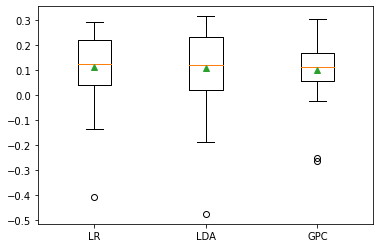

In [69]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler





# define models to test
def get_models():
    models, names = list(), list()

    # LR
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR')

    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')

    # GPC
    models.append(GaussianProcessClassifier())
    names.append('GPC')
    return models, names



# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):

    # create a pipeline
    steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m',models[i])]
    pipeline = Pipeline(steps=steps)

    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)

    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In this case, i can see a further lift in model skill for the three models that were evaluated.
i can see that the LR appears to have out-performed the other two methods.

Box and whisker plots are created for the results from each algorithm, suggesting perhaps
a smaller and more focused spread for LR compared to the LDA, which was the second-best
performing method. All methods still show skill on average, however the distribution of scores
show runs that drop below 0.0 (no skill) in some cases.

## Make Prediction on New Data
I will select the Logistic Regression model with a power transform on the input data as our
final model. We can define and fit this model on the entire training dataset.
i can use the fit model to make some predictions of probability for a
few cases where we know there is survival and a few where we know there is not.

In [72]:
# fit a model and make predictions for the haberman dataset
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler


# load the dataset
def load_dataset(full_path):

    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)

    # retrieve numpy array
    data = data.values

    #split into input and output elements
    X, y = data[:, :-1], data[:, -1]

    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)

    return X, y


# fit the model
steps = [('t1', MinMaxScaler()),('t2', PowerTransformer()),('m',LogisticRegression(solver='lbfgs'))]
model = Pipeline(steps=steps)
model.fit(X, y)

# some survival cases
print('Survival Cases:')
data = [[31,59,2], [31,65,4], [34,60,1]]


for row in data:
    # make prediction
    yhat = model.predict_proba([row])

    # get percentage of survival
    p_survive = yhat[0, 0] * 100

    # summarize
    print('>data=%s, Survival=%.3f%%' % (row, p_survive))


print('Non-Survival Cases:')
data = [[44,64,6], [34,66,9], [38,69,21]]
for row in data:
    # make prediction
    yhat = model.predict_proba([row])

    # get percentage of survival
    p_survive = yhat[0, 0] * 100

    # summarize
    print('>data=%s, Survival=%.3f%%' % (row, p_survive))

Survival Cases:
>data=[31, 59, 2], Survival=83.597%
>data=[31, 65, 4], Survival=77.264%
>data=[34, 60, 1], Survival=86.776%
Non-Survival Cases:
>data=[44, 64, 6], Survival=63.092%
>data=[34, 66, 9], Survival=63.452%
>data=[38, 69, 21], Survival=53.389%
